In [1]:
!mkdir /root/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [2]:
!cp kaggle.json /root/.kaggle

In [2]:
import kaggle

In [4]:
!chmod 600 /root/.kaggle/kaggle.json

# [Dataset link](https://www.kaggle.com/datasets/splcher/animefacedataset)

In [4]:
kaggle.api.dataset_download_files('splcher/animefacedataset')
!unzip animefacedataset.zip -d animefacedataset/

Archive:  animefacedataset.zip
replace animefacedataset/images/0_2000.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [5]:
import os

DATA_DIR = './animefacedataset'
print(os.listdir(DATA_DIR))

['images']


In [6]:
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as T
import cv2
import os
import torch.nn as nn
from torchvision.utils import save_image

In [7]:
image_size = 64
batch_size = 128
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

In [8]:
train_ds = ImageFolder(DATA_DIR, transform=T.Compose([
    T.Resize(image_size),
    T.CenterCrop(image_size),
    T.ToTensor(),
    T.Normalize(*stats)]))

train_dl = DataLoader(train_ds, batch_size, shuffle=True, pin_memory=True)

In [9]:
import torch
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import torch.nn.functional as F

In [10]:
def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]

In [11]:
def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))

def show_batch(dl, nmax=64):
    for images, _ in dl:
        show_images(images, nmax)
        break

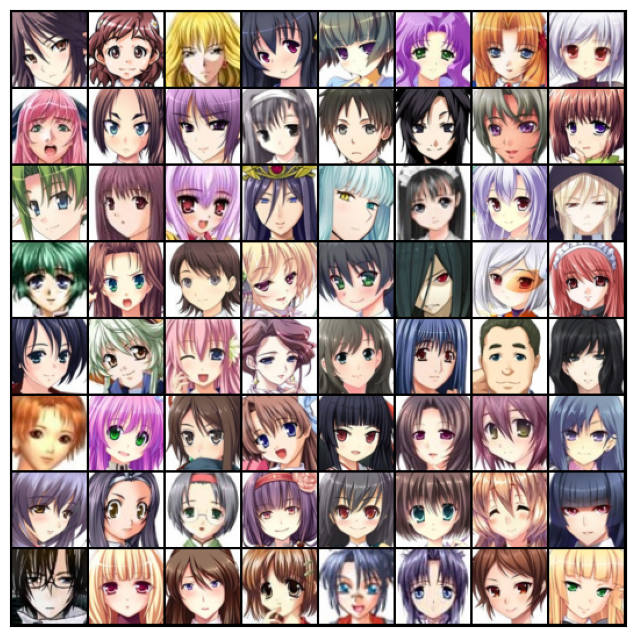

In [12]:
show_batch(train_dl)

In [13]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [14]:
device = get_default_device()
device

device(type='cuda')

In [15]:
train_dl = DeviceDataLoader(train_dl, device)

In [16]:
discriminator = nn.Sequential(
    # in: 3 x 64 x 64

    nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 64 x 32 x 32

    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 128 x 16 x 16

    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 256 x 8 x 8

    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 512 x 4 x 4

    nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
    # out: 1 x 1 x 1

    nn.Flatten(),
    nn.Sigmoid())

In [17]:
discriminator = to_device(discriminator, device)

In [18]:
latent_size = 128

In [19]:
generator = nn.Sequential(
    # in: latent_size x 1 x 1

    nn.ConvTranspose2d(latent_size, 512, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    # out: 512 x 4 x 4

    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    # out: 256 x 8 x 8

    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    # out: 128 x 16 x 16

    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    # out: 64 x 32 x 32

    nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh()
    # out: 3 x 64 x 64
)

torch.Size([128, 3, 64, 64])


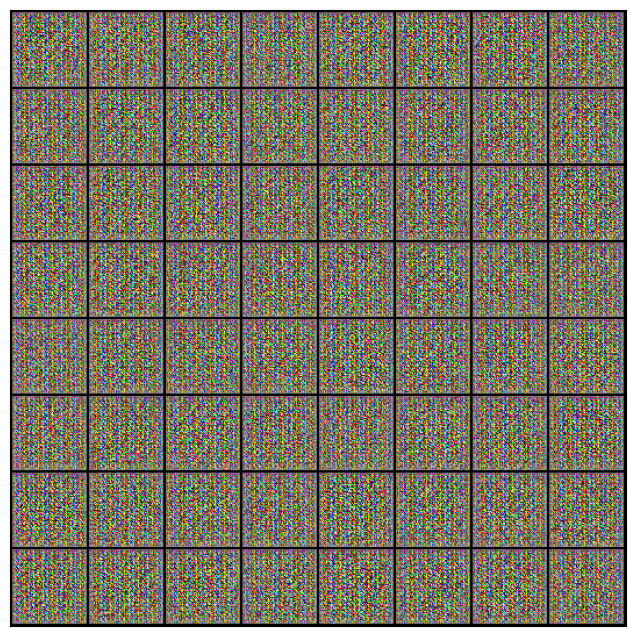

In [20]:
xb = torch.randn(batch_size, latent_size, 1, 1) # random latent tensors
fake_images = generator(xb)
print(fake_images.shape)
show_images(fake_images)

In [21]:
generator = to_device(generator, device)

In [22]:
def train_discriminator(real_images, opt_d):
    # Clear discriminator gradients
    opt_d.zero_grad()

    # Pass real images through discriminator
    real_preds = discriminator(real_images)
    real_targets = torch.ones(real_images.size(0), 1, device=device)
    real_loss = F.binary_cross_entropy(real_preds, real_targets)
    real_score = torch.mean(real_preds).item()

    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)

    # Pass fake images through discriminator
    fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
    fake_preds = discriminator(fake_images)
    fake_loss = F.binary_cross_entropy(fake_preds, fake_targets)
    fake_score = torch.mean(fake_preds).item()

    # Update discriminator weights
    loss = real_loss + fake_loss
    loss.backward()
    opt_d.step()
    return loss.item(), real_score, fake_score

In [23]:
def train_generator(opt_g):
    # Clear generator gradients
    opt_g.zero_grad()

    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)

    # Try to fool the discriminator
    preds = discriminator(fake_images)
    targets = torch.ones(batch_size, 1, device=device)
    loss = F.binary_cross_entropy(preds, targets)

    # Update generator weights
    loss.backward()
    opt_g.step()

    return loss.item()

In [24]:
sample_dir = 'generated'
os.makedirs(sample_dir, exist_ok=True)

In [25]:
def save_samples(index, latent_tensors, show=True):
    fake_images = generator(latent_tensors)
    fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
    print('Saving', fake_fname)
    if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))

In [26]:
fixed_latent = torch.randn(64, latent_size, 1, 1, device=device)

Saving generated-images-0000.png


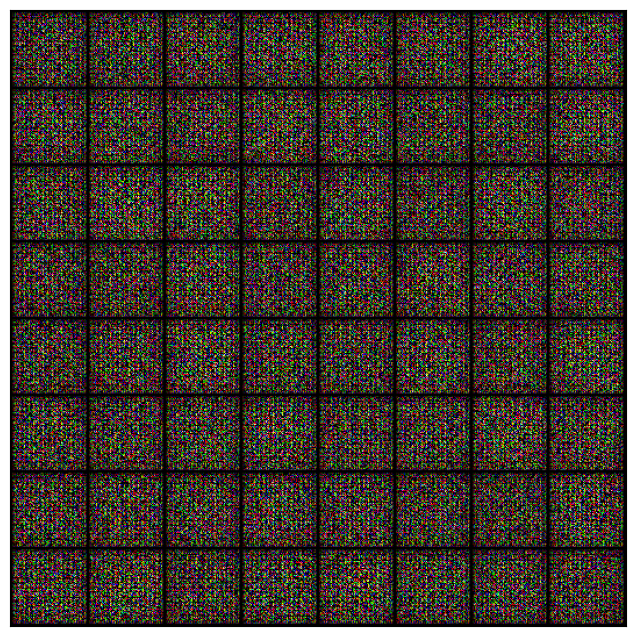

In [27]:
save_samples(0, fixed_latent)

In [28]:
def fit(epochs, lr, start_idx=1):
    # Losses & scores
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []

    # Create optimizers
    opt_d = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
    opt_g = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))

    for epoch in range(epochs):
        torch.cuda.empty_cache()
        for real_images, _ in tqdm(train_dl):
            # Train discriminator
            loss_d, real_score, fake_score = train_discriminator(real_images, opt_d)
            # Train generator
            loss_g = train_generator(opt_g)

        # Record losses & scores
        losses_g.append(loss_g)
        losses_d.append(loss_d)
        real_scores.append(real_score)
        fake_scores.append(fake_score)

        # Log losses & scores (last batch)
        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch+1, epochs, loss_g, loss_d, real_score, fake_score))

        if epoch%5==0:
            # Save generated images
            save_samples(epoch+start_idx, fixed_latent, show=False)

    return losses_g, losses_d, real_scores, fake_scores

In [29]:
lr = 0.0002
epochs = 30
history = fit(epochs, lr)

  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [1/30], loss_g: 4.1270, loss_d: 0.4811, real_score: 0.7775, fake_score: 0.1472
Saving generated-images-0001.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [2/30], loss_g: 5.0386, loss_d: 0.3215, real_score: 0.9103, fake_score: 0.1754


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [3/30], loss_g: 6.9735, loss_d: 0.5625, real_score: 0.8752, fake_score: 0.3177


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [4/30], loss_g: 2.6044, loss_d: 0.0773, real_score: 0.9452, fake_score: 0.0144


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [5/30], loss_g: 6.2936, loss_d: 0.1153, real_score: 0.9325, fake_score: 0.0394


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [6/30], loss_g: 7.1331, loss_d: 0.1381, real_score: 0.8979, fake_score: 0.0063
Saving generated-images-0006.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [7/30], loss_g: 7.0078, loss_d: 0.0776, real_score: 0.9609, fake_score: 0.0279


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [8/30], loss_g: 0.2342, loss_d: 0.9978, real_score: 0.5656, fake_score: 0.0176


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [9/30], loss_g: 5.2804, loss_d: 0.1024, real_score: 0.9527, fake_score: 0.0202


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [10/30], loss_g: 7.3319, loss_d: 0.1721, real_score: 0.8704, fake_score: 0.0017


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [11/30], loss_g: 7.8996, loss_d: 0.1572, real_score: 0.9625, fake_score: 0.1015
Saving generated-images-0011.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [12/30], loss_g: 5.2850, loss_d: 0.1691, real_score: 0.8830, fake_score: 0.0077


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [13/30], loss_g: 6.4066, loss_d: 0.0797, real_score: 0.9544, fake_score: 0.0249


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [14/30], loss_g: 5.0307, loss_d: 0.1118, real_score: 0.9613, fake_score: 0.0558


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [15/30], loss_g: 9.4681, loss_d: 0.1357, real_score: 0.9975, fake_score: 0.1115


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [16/30], loss_g: 4.4785, loss_d: 0.1421, real_score: 0.9112, fake_score: 0.0218
Saving generated-images-0016.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [17/30], loss_g: 6.0027, loss_d: 0.0945, real_score: 0.9346, fake_score: 0.0072


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [18/30], loss_g: 8.4206, loss_d: 0.0408, real_score: 0.9994, fake_score: 0.0328


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [19/30], loss_g: 5.1912, loss_d: 0.1424, real_score: 0.9313, fake_score: 0.0370


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [20/30], loss_g: 9.4602, loss_d: 0.2257, real_score: 0.8646, fake_score: 0.0006


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [21/30], loss_g: 6.7010, loss_d: 0.1579, real_score: 0.9529, fake_score: 0.0858
Saving generated-images-0021.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [22/30], loss_g: 7.0981, loss_d: 0.0876, real_score: 0.9307, fake_score: 0.0082


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [23/30], loss_g: 4.9680, loss_d: 0.0786, real_score: 0.9514, fake_score: 0.0135


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [24/30], loss_g: 5.4817, loss_d: 0.1033, real_score: 0.9463, fake_score: 0.0311


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [25/30], loss_g: 5.5090, loss_d: 0.0886, real_score: 0.9715, fake_score: 0.0539


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [26/30], loss_g: 6.5922, loss_d: 0.1332, real_score: 0.9036, fake_score: 0.0026
Saving generated-images-0026.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [27/30], loss_g: 5.8923, loss_d: 0.0472, real_score: 0.9935, fake_score: 0.0356


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [28/30], loss_g: 7.1456, loss_d: 0.0406, real_score: 0.9717, fake_score: 0.0105


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [29/30], loss_g: 4.6332, loss_d: 0.0370, real_score: 0.9950, fake_score: 0.0288


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [30/30], loss_g: 6.1169, loss_d: 0.0655, real_score: 0.9789, fake_score: 0.0369


In [30]:
losses_g, losses_d, real_scores, fake_scores = history

In [31]:
# Save the model checkpoints
torch.save(generator.state_dict(), 'G.pth')
torch.save(discriminator.state_dict(), 'D.pth')

In [32]:
from IPython.display import Image

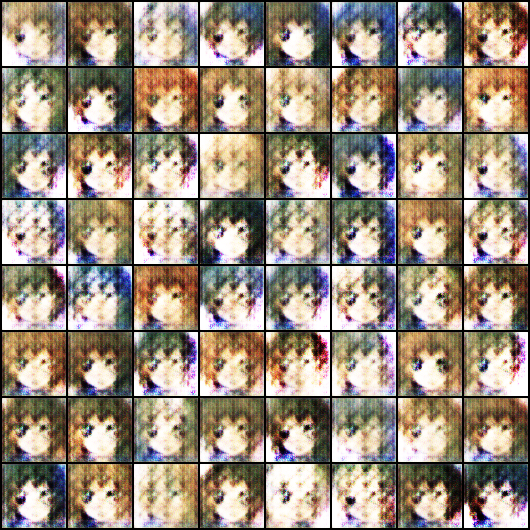

In [44]:
Image('./generated/generated-images-0001.png')

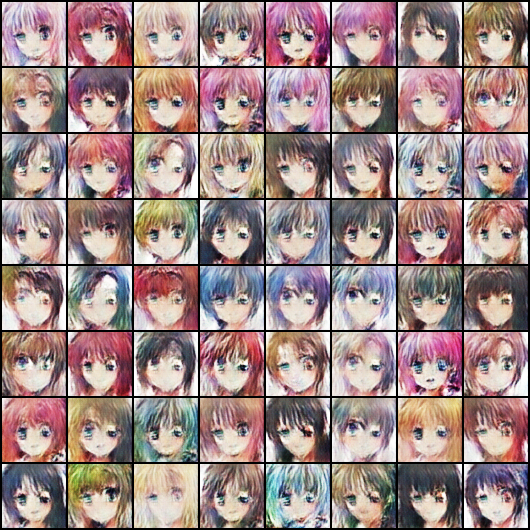

In [42]:
Image('./generated/generated-images-0006.png')

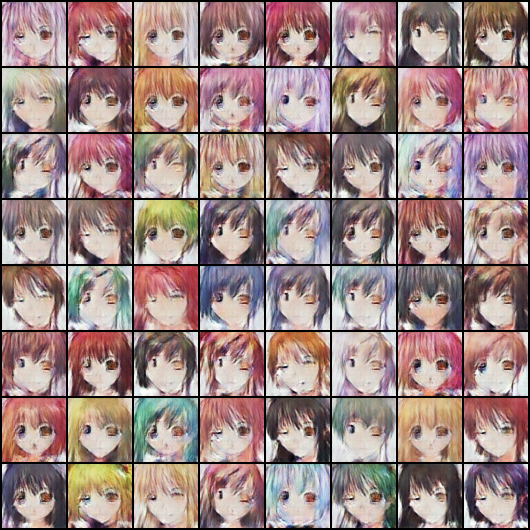

In [43]:
Image('./generated/generated-images-0011.png')

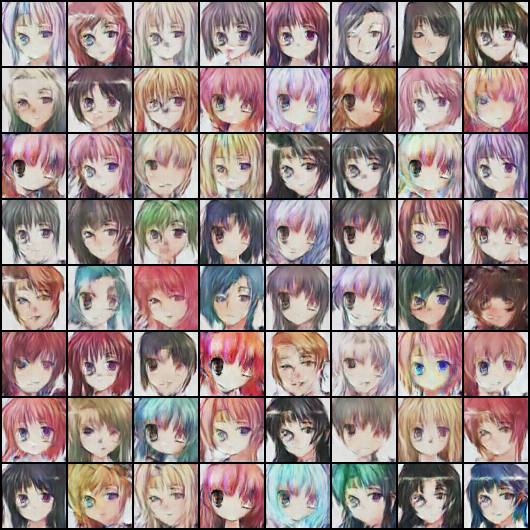

In [46]:
Image('./generated/generated-images-0021.png')

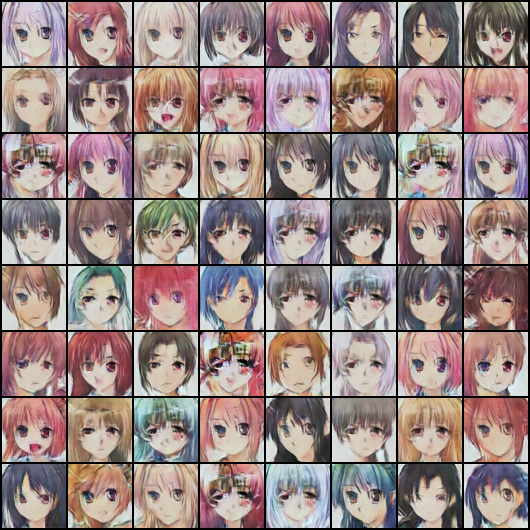

In [47]:
Image('./generated/generated-images-0026.png')

In [48]:
vid_fname = 'gans_training.avi'

files = [os.path.join(sample_dir, f) for f in os.listdir(sample_dir) if 'generated' in f]
files.sort()

out = cv2.VideoWriter(vid_fname,cv2.VideoWriter_fourcc(*'MP4V'), 1, (530,530))
[out.write(cv2.imread(fname)) for fname in files]
out.release()

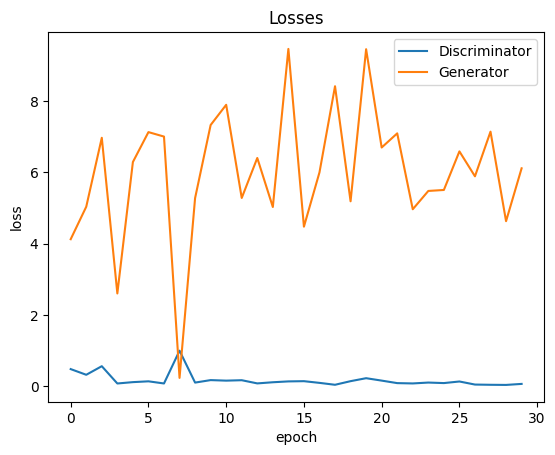

In [49]:
plt.plot(losses_d, '-')
plt.plot(losses_g, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses');

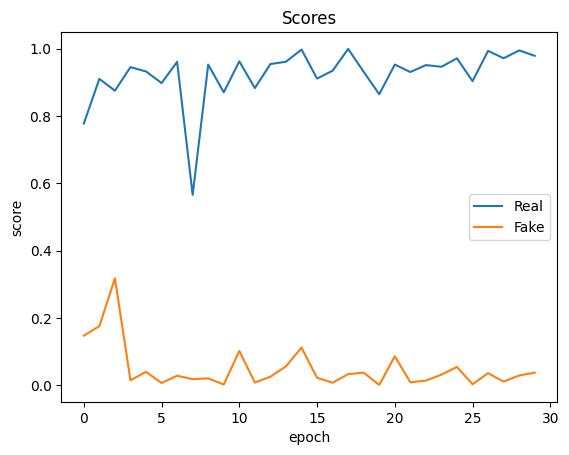

In [50]:
plt.plot(real_scores, '-')
plt.plot(fake_scores, '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real', 'Fake'])
plt.title('Scores');